**Import Necessary libraries**

In [1]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings('ignore')

**Data Preparation**

In [2]:
df = pd.read_csv('cleaned_data_videoGames.csv')
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1351 non-null   object 
 1   Platform      1351 non-null   object 
 2   Year          1351 non-null   int64  
 3   Genre         1351 non-null   object 
 4   Publisher     1351 non-null   object 
 5   NA_ Sales     1351 non-null   float64
 6   EU_Sales      1351 non-null   float64
 7   JP_Sales      1351 non-null   float64
 8   Other_Sales   1351 non-null   float64
 9   Global_Sales  1351 non-null   float64
 10  Critic_Score  1351 non-null   float64
 11  User_Score    1351 non-null   float64
 12  Rating        1350 non-null   object 
 13  Total_Sales   1351 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 147.9+ KB


In [4]:
print(df.isnull().sum())


Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_ Sales       0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
User_Score      0
Rating          1
Total_Sales     0
dtype: int64


**Feature Engineering**

In [5]:
# Creating a new feature "Total_Critic_Score" by adding Critic_Score and User_Score
df['Total_Critic_Score'] = df['Critic_Score'] + df['User_Score']

# Creating a new feature "Sales_Per_Year" by dividing Global_Sales by Year
df['Sales_Per_Year'] = df['Global_Sales'] / df['Year']


In [6]:
le = LabelEncoder()
df['Platform_Encoded']=le.fit_transform(df['Platform'])
df['Genre_Encoded'] = le.fit_transform(df['Genre'])
df['Rating_Encoded'] = le.fit_transform(df['Rating'])

In [7]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales,Total_Critic_Score,Sales_Per_Year,Platform_Encoded,Genre_Encoded,Rating_Encoded
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74,84.0,0.041246,14,10,0
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83,90.3,0.017839,14,6,0
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00,88.0,0.016426,14,10,0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01,97.5,0.014960,2,4,0
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01,64.6,0.014467,14,3,0


In [8]:
# Using StandardScaler to scale the numerical feature "Global_Sales"
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Global_Sales_Scaled'] = scaler.fit_transform(df[['Global_Sales']])


In [9]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales,Total_Critic_Score,Sales_Per_Year,Platform_Encoded,Genre_Encoded,Rating_Encoded,Global_Sales_Scaled
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74,84.0,0.041246,14,10,0,21.280205
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83,90.3,0.017839,14,6,0,8.796565
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00,88.0,0.016426,14,10,0,8.046269
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01,97.5,0.014960,2,4,0,7.250743
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01,64.6,0.014467,14,3,0,6.987342


I'm going  to perform a time series decomposition, and an auto correlation analysis to fit a SARIMA model for forecasting. This evaluates using RMSE as this will be the primary evaluation method for my models.

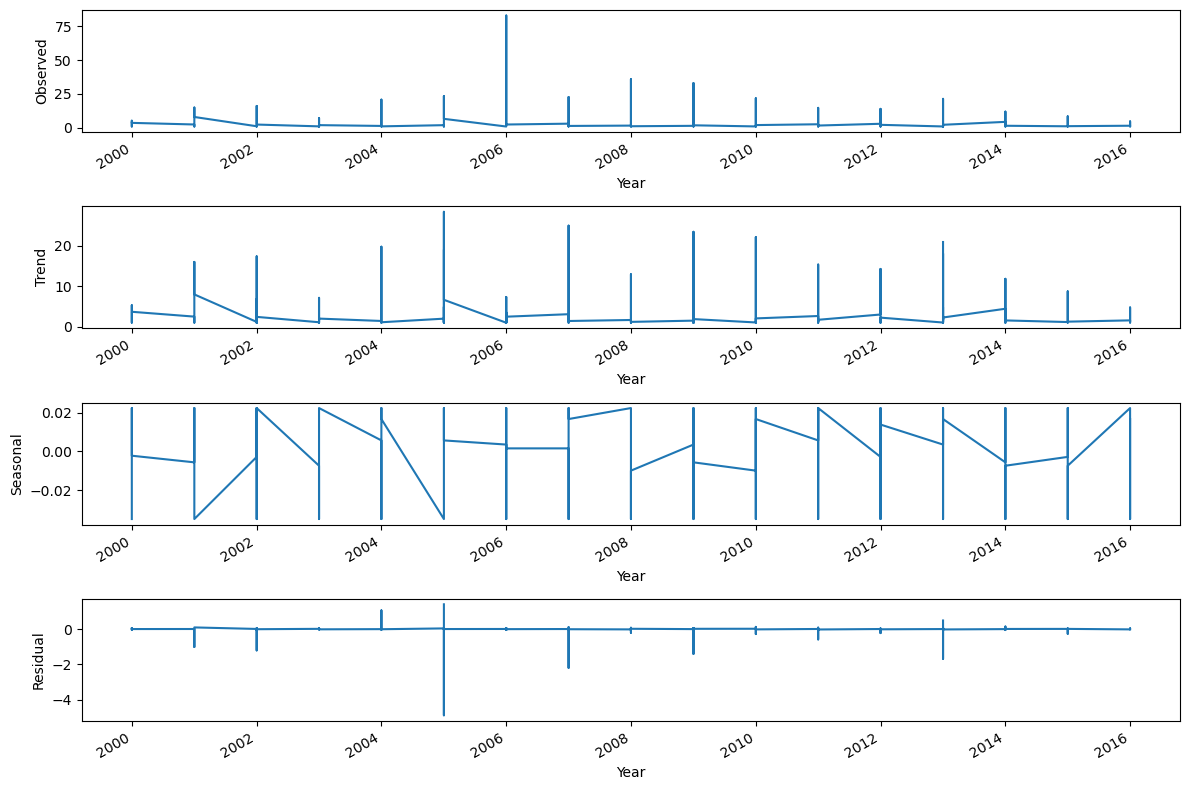

In [10]:

df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index("Year")

# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df["Global_Sales"], model="additive", period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel("Observed")
decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel("Trend")
decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel("Seasonal")
decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel("Residual")
plt.tight_layout()



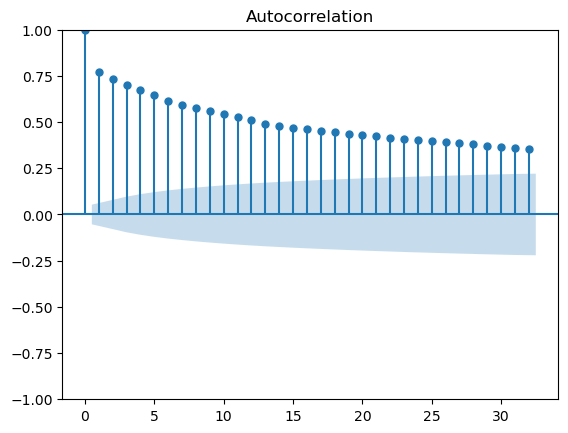

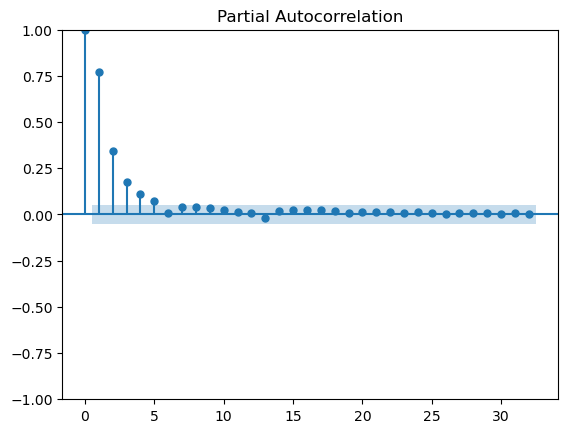

In [11]:
# Autocorrelation analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df["Global_Sales"])
plt.show()

plot_pacf(df["Global_Sales"])
plt.show()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40821D+01    |proj g|=  2.50668D+02


 This problem is unconstrained.



At iterate    5    f=  1.63450D+00    |proj g|=  1.86812D-01

At iterate   10    f=  1.50077D+00    |proj g|=  4.77289D-02

At iterate   15    f=  1.49367D+00    |proj g|=  3.50973D-03

At iterate   20    f=  1.49351D+00    |proj g|=  3.29446D-03

At iterate   25    f=  1.49338D+00    |proj g|=  5.61193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   5.046D-04   1.493D+00
  F =   1.4933826780988579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


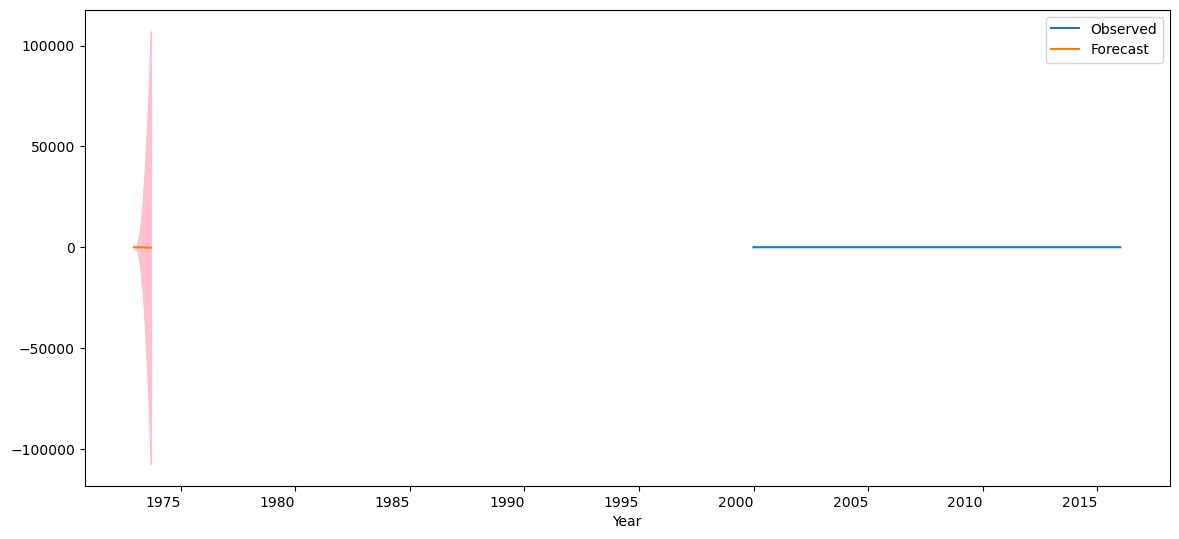

In [12]:
# Split the data into training and testing sets
train = df[:int(0.8 * len(df))]
test = df[int(0.8 * len(df)):]

# Fit the SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

sarima_model = SARIMAX(train["Global_Sales"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Forecasting
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_confidence_interval = forecast.conf_int()

# Model Evaluation
test["Global_Sales"].plot(label="Observed")
forecast.predicted_mean.plot(label="Forecast", figsize=(14, 7))
plt.fill_between(forecast_confidence_interval.index,
                 forecast_confidence_interval.iloc[:, 0],
                 forecast_confidence_interval.iloc[:, 1], color='pink')
plt.legend()
plt.show()


In [13]:

# Calculate RMSE
rmse = sqrt(mean_squared_error(test["Global_Sales"], forecast.predicted_mean))
print('RMSE:', rmse)

RMSE: 115.35924420582276


**Applying the Machine Learning models:**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report, roc_auc_score

In [15]:
# Prepare the dataset
df_clean = df.drop(columns=['Name', 'Rating'])  # Drop unnecessary columns
df_dummies = pd.get_dummies(df_clean, columns=['Genre', 'Platform', 'Publisher'])

# Define features (X) and target variable (y)
X = df_dummies.drop('Global_Sales', axis=1)  # Drop the target variable
y = df_dummies['Global_Sales']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
threshold = df_clean['Global_Sales'].quantile(0.75)
df_clean['Success'] = df_clean['Global_Sales'] > threshold

In [22]:
df_dummies = pd.get_dummies(df_clean, columns=['Genre', 'Platform', 'Publisher'])

features = ['Publisher', 'Platform', 'Genre', 'Critic_Score', 'User_Score']

X = df_clean[features]
y = df_clean['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict success for the test set
y_pred = clf.predict(X_test)

ValueError: could not convert string to float: 'Square Enix'

,Platform,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Total_Sales,Total_Critic_Score,Sales_Per_Year,Platform_Encoded,Genre_Encoded,Rating_Encoded,Global_Sales_Scaled,Success
Year,,,,,,,,,,,,,,,,,,
2006-01-01,Wii,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,82.74,84.0,0.041246,14,10,0,21.280205,True
2008-01-01,Wii,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,35.83,90.3,0.017839,14,6,0,8.796565,True
2009-01-01,Wii,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,33.00,88.0,0.016426,14,10,0,8.046269,True
2006-01-01,DS,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,30.01,97.5,0.014960,2,4,0,7.250743,True
2006-01-01,Wii,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,29.01,64.6,0.014467,14,3,0,6.987342,True
